In this notebook, we are going to implement POET model to estimate the covariance matrix for of the stock data with higer accuracy.

## Data Pre-processing

In [240]:
import pandas as pd
import numpy as np

# Data: The annual daily pricing data for 50 stocks over period Jan 1st - Dec 31 (2010). n = 252 (workdays in 2010)
p1 = pd.read_csv("POET_prices1.csv")
p2 = pd.read_csv("POET_prices2.csv")
prices = pd.concat([p1,p2],axis=1)
prices = prices.dropna(how='any')
print("Dimension of the data: ", prices.shape)
prices.tail()

Dimension of the data:  (50, 366)


,1/1/16,1/2/16,1/3/16,1/4/16,1/5/16,1/6/16,1/7/16,1/8/16,1/9/16,1/10/16,...,12/22/16,12/23/16,12/24/16,12/25/16,12/26/16,12/27/16,12/28/16,12/29/16,12/30/16,12/31/16
45,26.54,26.54,26.54,26.14,26.23,26.29,26.24,25.90,25.90,25.90,...,41.67,42.16,42.16,42.16,42.16,42.65,41.84,42.33,42.94,42.94
46,24.94,24.94,24.94,24.76,24.84,24.99,24.62,24.69,24.69,24.69,...,38.60,38.75,38.75,38.75,38.75,39.10,38.00,38.10,38.20,38.20
47,41.95,41.95,41.95,40.50,40.79,41.35,40.49,40.46,40.46,40.46,...,45.28,45.64,45.64,45.64,45.64,46.05,45.32,45.68,45.56,45.56
48,27.70,27.70,27.70,26.39,26.82,27.25,27.14,27.44,27.44,27.44,...,31.84,31.77,31.77,31.77,31.77,32.56,31.95,31.92,31.94,31.94
49,4.80,4.80,4.80,4.78,4.64,4.63,4.53,4.55,4.55,4.55,...,5.55,5.60,5.60,5.60,5.60,5.60,5.30,5.15,5.50,5.50


In [241]:
# Transform price information into returns
prices_second_day = prices.iloc[:,1:]
prices_previous_day = prices.iloc[:,0:-1]
daily_returns = prices_second_day/ prices_previous_day.values
daily_returns = np.log(daily_returns)

# Delete the columns with all 0s
daily_returns = daily_returns.loc[:,(daily_returns!=0).any()] 
print("Dimension of the data: ", daily_returns.shape)

# Convert from decimal to percentile
daily_returns *= 100
daily_returns.head()

Dimension of the data:  (50, 252)


,1/4/16,1/5/16,1/6/16,1/7/16,1/8/16,1/11/16,1/12/16,1/13/16,1/14/16,1/15/16,...,12/16/16,12/19/16,12/20/16,12/21/16,12/22/16,12/23/16,12/27/16,12/28/16,12/29/16,12/30/16
0,-0.475141,1.368380,-0.673403,-2.341387,-0.155750,1.042349,0.640672,-1.995250,1.294572,-1.242466,...,0.716615,-0.203062,0.276064,-0.121699,0.437425,-0.469903,-0.056862,-0.317396,0.089624,-0.875225
1,-1.580423,1.388239,-1.437015,-2.703313,-1.650981,1.148467,0.652777,-1.954240,-0.460398,-1.636980,...,-0.724003,-0.137565,1.831696,0.979929,-0.306396,-0.442096,-1.201565,-0.527809,0.078370,-0.451468
2,-2.992869,0.667182,-0.890569,-2.508405,-0.105895,2.079586,2.796908,-2.710470,1.899929,-1.675539,...,-0.086678,-0.017345,0.086693,-0.451625,-0.576169,-0.175254,-0.263458,-0.900987,-0.053253,-1.430640
3,-2.858588,-1.550650,-3.252940,-0.904419,-0.329490,0.657897,0.544960,-2.436270,0.697640,-0.602221,...,0.080032,-0.601807,0.681775,0.345791,-0.987333,0.521566,0.013338,-0.816878,-0.606921,0.216216
4,-2.015182,-1.826014,-1.318764,-5.194612,-1.314689,0.821774,1.593171,-3.337763,1.497221,-2.746348,...,-0.766543,0.411775,0.642092,-0.198829,-1.391772,0.547885,0.089166,-1.764586,-1.232189,0.149125


## POET Model
Now that we have got the matrix of stock daily return, we are going to apply POET Model to generate/ estimate a more accurate covariance matrix.

In [242]:
# Deduct row averages to get better performance
de_meaned_mat = daily_returns.sub(daily_returns.mean(axis=1), axis=0)
de_meaned_mat.head()

,1/4/16,1/5/16,1/6/16,1/7/16,1/8/16,1/11/16,1/12/16,1/13/16,1/14/16,1/15/16,...,12/16/16,12/19/16,12/20/16,12/21/16,12/22/16,12/23/16,12/27/16,12/28/16,12/29/16,12/30/16
0,-0.486987,1.356534,-0.685250,-2.353233,-0.167596,1.030503,0.628825,-2.007097,1.282726,-1.254313,...,0.704769,-0.214909,0.264217,-0.133545,0.425578,-0.481749,-0.068708,-0.329242,0.077778,-0.887072
1,-1.498407,1.470254,-1.354999,-2.621297,-1.568965,1.230483,0.734792,-1.872224,-0.378382,-1.554964,...,-0.641987,-0.055549,1.913712,1.061945,-0.224380,-0.360080,-1.119549,-0.445793,0.160386,-0.369452
2,-2.961876,0.698175,-0.859577,-2.477413,-0.074902,2.110578,2.827901,-2.679478,1.930921,-1.644547,...,-0.055685,0.013648,0.117685,-0.420632,-0.545177,-0.144262,-0.232466,-0.869994,-0.022260,-1.399647
3,-2.883627,-1.575689,-3.277980,-0.929459,-0.354529,0.632858,0.519921,-2.461309,0.672601,-0.627260,...,0.054992,-0.626847,0.656736,0.320751,-1.012372,0.496526,-0.011702,-0.841917,-0.631960,0.191177
4,-2.090380,-1.901212,-1.393963,-5.269811,-1.389887,0.746575,1.517973,-3.412962,1.422022,-2.821546,...,-0.841741,0.336577,0.566894,-0.274028,-1.466971,0.472687,0.013968,-1.839785,-1.307387,0.073927


### Matrix 1: PCA  on sample covariance matrix

First we have to decide the number of principle components, i.e. K

$\hat{K} = argmin_{0 \leq K_{1}\leq M } log(\frac{1}{pT}||Y - T^{-1} Y \hat{F_{K_{1}}} \hat{F^{'}_{K_{1}}}||^{2}_{F}) + K_{1}g(T,p)$

$\hat{F}_{K1}$ is a $T \times K_1$ matrix whose columns are $\sqrt{T}$ times the eigenvectors corresponding to the $K_1$ largest eigenvalues of the $T \times T$ matrix $Y'Y$

$g(T,p) = \frac{p+T}{pT}log(\frac{pT}{p+T})$

In [243]:
from sklearn.decomposition import PCA
import math

# First we look for k
p = de_meaned_mat.shape[0]
T = de_meaned_mat.shape[1]
Y = de_meaned_mat.values #(50*252)

def g(p, T):
    return (p+T)* math.log((p*T)/(p+T))/(p*T)

min_evaluator = np.inf
estimated_k = 0

for k in range(1,10):
    pca = PCA(n_components=k)
    result = pca.fit((Y.T) @ Y)
    F = (pca.components_.T)
    evaluator = math.log(1/(p*T)* np.square(np.linalg.norm(Y - (1/T)*(Y @ np.dot(F,F.T))))) + k*g(p,T)
    #print(evaluator)
    if evaluator < min_evaluator:
        min_evaluator = evaluator
        estimated_k = k
        
print("K found: ",estimated_k)

K found:  1


We know $Var(C_i)$ is the eigenvalue of the covariance matrix for $X_i$, and the eigenvector of the matrix is the vector for coefficients.

$ \sum_{i=1}^{K} \hat{\lambda}_{i} \hat{\xi}_{i} \hat{\xi}_{i}^{'} $

In [244]:
# Get matrix 1
e_values, e_vectors = np.linalg.eig(np.cov(Y)) # 50*1
matrix1 = np.zeros([p,p])
for k in range(estimated_k):
    matrix1 += e_values[k] * (e_vectors[:,k].reshape(p,1) @ e_vectors[:,k].reshape(1,p)) # eigen-decomposition
    
# Now that we've got matrix1. We subtract matrix1 from the covariance matrix to get matrix2   
matrix2 = np.cov(Y) - matrix1

In [245]:
pd.DataFrame(matrix2).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.826631,0.312731,0.444077,-0.036779,0.013314,0.177122,0.109953,0.355197,0.126759,0.119455,...,-0.098820,0.043753,0.331352,0.160522,0.231496,0.394734,0.388187,0.455354,0.290470,0.039301
1,0.312731,1.623905,0.681817,0.044976,0.099122,0.135710,-0.034607,0.313168,0.439603,0.388972,...,-0.518991,-0.155665,0.271331,0.089046,-0.032234,0.100307,0.047703,0.055067,0.110980,-0.005698
2,0.444077,0.681817,1.289297,-0.003301,0.079910,0.261665,0.126382,0.481544,0.421205,0.267693,...,-0.282216,-0.013023,0.494574,0.165073,0.187681,0.383905,0.531870,0.350648,0.194926,0.248134
3,-0.036779,0.044976,-0.003301,1.787338,0.621465,0.085582,-0.233200,-0.164227,-0.071534,0.069026,...,-0.325716,-0.058755,-0.170267,-0.061293,-0.283128,-0.226225,-0.003512,-0.211230,-0.443572,-0.406958
4,0.013314,0.099122,0.079910,0.621465,1.569984,-0.054189,-0.282033,-0.077135,-0.144830,-0.081115,...,-0.656807,0.090061,-0.239516,-0.041189,-0.471650,-0.360813,-0.353233,-0.201498,-0.548588,-0.180713


In [246]:
print(matrix1.shape)
print(matrix2.shape)

(50, 50)
(50, 50)


### Matrix 2: Thresholding

$\tau_{ij} = Cw_T\sqrt{\hat{\theta}_{ij}}$

- $\omega_{T}= \frac{1}{\sqrt{p}} + \sqrt( \frac{log(p)}{T}) $  (Constant)

- $\hat{\theta}_{ij}=\frac{1}{T}\sum^T _{t=1}(\hat{u}_{it}\hat{u}_{jt}-\hat{\sigma}_{ij})^2$ 

  $\hat{u}_{it} = y_{it} - bf$  # To be found using least square method
  
  $\hat{\sigma}_{ij} = \frac{1}{T}\sum_{t=1}^{T}\hat{u}_{it}\hat{u}_{jt}$

In [247]:
# find omega
omega = 1/ np.sqrt(p) + np.sqrt(np.log(p)/T)

# find matrix of theta
I = np.zeros([p,p])
for i in range(p):
    I[i][i] = 1
hat_u_mat = (I - (e_vectors[:,0:estimated_k].reshape(50,estimated_k) @ e_vectors[:,0:estimated_k].reshape(50,estimated_k).T)) @ Y # least sqaure error
        
hat_sigma_mat = np.empty([p,p])
for i in range(p):
    for j in range(p):
        value = 0
        for t in range(T):
            value += hat_u_mat[i][t] * hat_u_mat[j][t]
        hat_sigma_mat[i][j] = value / T

hat_theta_mat = np.zeros([p,p])
for i in range(p):
    for j in range(p):
        value = 0
        for t in range(T):
            value += (hat_u_mat[i][t] * hat_u_mat[j][t] - hat_sigma_mat[i][j])**2
        hat_theta_mat[i][j] = value / T

__Find C__
1. decide $C_{min}$ by choosing the smallest threshold C that guarantees the covaricance matrix is positive definite

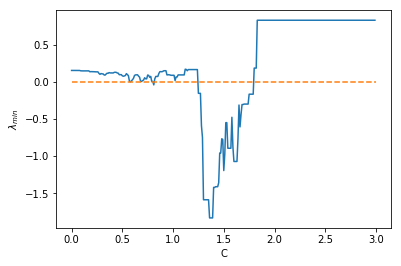

In [248]:
import matplotlib.pyplot as plt
import copy

# We perform thresholding on the covariance matrix, testing different values of C
eigen_list = []
x_axis = []
def is_pos_def(mat):
    eigen_list.append(min(np.linalg.eigvals(mat)))
    if min(np.linalg.eigvals(mat))> 0:
        return True
    else:
        return False

def thresholding(C,mat): 
    c_mat = copy.deepcopy(mat)
    for i in range(p):
        for j in range(p):
            if i==j:
                continue
            elif c_mat[i][j] < C * omega * np.sqrt(hat_theta_mat[i][j]):
                c_mat[i][j] = 0
    if is_pos_def(c_mat):
        return True
    else:
        return False

def find_min_C(mat):
    for C in range(0,3):
        if thresholding(C,mat):
            return C
        
for C in np.arange(0,3,0.01):
    x_axis.append(C)
    thresholding(C,matrix2)

plt.plot(x_axis, eigen_list,[0,3],[0,0],'--')
plt.xlabel("C")
plt.ylabel(r"$\lambda_{min}$")
plt.show()

2. Now that we've found min_C to be 0, we continue to find the optimal C using cross-validation

$C^* = argmin \frac{1}{H} \sum _{j=1}^{H}||\hat{\sum}_{u}^{\tau,j}(C) - \hat{\sum}_{u}^{j}||_F ^2$


In [249]:
from sklearn.model_selection import train_test_split
# We split the residuals obtained by PCA into two parts
opt_C = 0
hat_u_mat = hat_u_mat.T


def do_thresholding(C,c_mat): 
    for i in range(p):
        for j in range(p):
            if i==j:
                continue
            elif np.abs(c_mat[i][j]) < C * omega * np.sqrt(hat_theta_mat[i][j]):
                c_mat[i][j] = 0
                
min_error = np.inf                
for C in np.arange(2, 50, 1):
    sum_error = 0
    H = 10
    num = H
    for h in range(H):
        train, test = train_test_split(hat_u_mat,test_size=0.5)
        cov_mat_train = np.cov(train,rowvar=False)
        do_thresholding(C,cov_mat_train)
#         if not is_pos_def(cov_mat_train):
#             num -= 1
#             continue
        cov_mat_test = np.cov(test,rowvar=False)
        sum_error += (np.linalg.norm(cov_mat_train-cov_mat_test))**2
    #if num != 0:
    sum_error /= num
#     else:
#         sum_error = np.inf
    if sum_error < min_error:
        min_error = sum_error
        opt_C = C

print("Optimal C found: ", opt_C)

Optimal C found:  39


__Retrieve the same output as R package:__

In [250]:
e_l, e_v = np.linalg.eig(Y.T @ Y)
LamPCA = Y @ e_v[:,:1] * np.sqrt(T) / T
Lowrank = LamPCA @ LamPCA.T
SigmaU = matrix2
SigmaY = Lowrank + matrix2
Factors = e_v[:,:1].T
Loadings = LamPCA

In [251]:
pd.DataFrame(SigmaU).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.826631,0.312731,0.444077,-0.036779,0.013314,0.177122,0.109953,0.355197,0.126759,0.119455,...,-0.098820,0.043753,0.331352,0.160522,0.231496,0.394734,0.388187,0.455354,0.290470,0.039301
1,0.312731,1.623905,0.681817,0.044976,0.099122,0.135710,-0.034607,0.313168,0.439603,0.388972,...,-0.518991,-0.155665,0.271331,0.089046,-0.032234,0.100307,0.047703,0.055067,0.110980,-0.005698
2,0.444077,0.681817,1.289297,-0.003301,0.079910,0.261665,0.126382,0.481544,0.421205,0.267693,...,-0.282216,-0.013023,0.494574,0.165073,0.187681,0.383905,0.531870,0.350648,0.194926,0.248134
3,-0.036779,0.044976,-0.003301,1.787338,0.621465,0.085582,-0.233200,-0.164227,-0.071534,0.069026,...,-0.325716,-0.058755,-0.170267,-0.061293,-0.283128,-0.226225,-0.003512,-0.211230,-0.443572,-0.406958
4,0.013314,0.099122,0.079910,0.621465,1.569984,-0.054189,-0.282033,-0.077135,-0.144830,-0.081115,...,-0.656807,0.090061,-0.239516,-0.041189,-0.471650,-0.360813,-0.353233,-0.201498,-0.548588,-0.180713


In [228]:
pd.DataFrame(SigmaY).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,(0.9304636240225836+0j),(0.5077153322260161+0j),(0.627604963371607+0j),(0.22885383007331722+0j),(0.41482811819167564+0j),(0.5130466932002842+0j),(0.42195874392289623+0j),(0.6979670247893937+0j),(0.4647810132559606+0j),(0.6428583020566264+0j),...,(0.6320446966764155+0j),(0.4435231651680193+0j),(0.41199076785456656+0j),(0.3229449509711952+0j),(0.3213525664340985+0j),(0.4849302618714857+0j),(0.47094483945635485+0j),(0.531559605342603+0j),(0.424289986383445+0j),(0.10488245408520323+0j)
1,(0.5077153322260161+0j),(1.9900602063543644+0j),(1.0264595840179125+0j),(0.5438005773482388+0j),(0.8531143409974598+0j),(0.7665341222622605+0j),(0.5513003792050375+0j),(0.9568479546512396+0j),(1.0743654658048225+0j),(1.3718570121575238+0j),...,(0.8534800864160965+0j),(0.5950526400902953+0j),(0.4227604519750421+0j),(0.3940557740957246+0j),(0.13650528034406098+0j),(0.2696840166364288+0j),(0.2031120741682848+0j),(0.19817213281209967+0j),(0.3622778689669173+0j),(0.11745647139822527+0j)
2,(0.627604963371607+0j),(1.0264595840179125+0j),(1.6136897383441309+0j),(0.46621521551491757+0j),(0.7896014213698941+0j),(0.855424767784154+0j),(0.6778645920967572+0j),(1.08740418242046+0j),(1.018672898781839+0j),(1.1928291447761525+0j),...,(1.0096150962453423+0j),(0.6935865396790878+0j),(0.637106374818597+0j),(0.45216156121485035+0j),(0.346506175624748+0j),(0.543330212731924+0j),(0.6781487177423106+0j),(0.4853449981464098+0j),(0.43145865356552815+0j),(0.3640529325241617+0j)
3,(0.22885383007331722+0j),(0.5438005773482388+0j),(0.46621521551491757+0j),(2.466902053035121+0j),(1.648651246639824+0j),(0.9449718923517008+0j),(0.5649990061900665+0j),(0.7126765560612635+0j),(0.7932223240706084+0j),(1.40803949783122+0j),...,(1.5440422528260442+0j),(0.9639696794419819+0j),(0.03602952049915306+0j),(0.3542310674222204+0j),(-0.053249473152115784+0j),(0.004522585992970007+0j),(0.20820683735396056+0j),(-0.016273597567319498+0j),(-0.10122136453936958+0j),(-0.23918144259961832+0j)
4,(0.41482811819167564+0j),(0.8531143409974598+0j),(0.7896014213698941+0j),(1.648651246639824+0j),(3.1226158107947217+0j),(1.2448124051062894+0j),(0.9244755576197248+0j),(1.248339069356279+0j),(1.1622827755438228+0j),(1.9428554248111733+0j),...,(2.169404212410495+0j),(1.6359486643170724+0j),(0.07230893857368559+0j),(0.586891184138593+0j),(-0.12418001913209875+0j),(-0.012029718124342281+0j),(-0.033212136847101226+0j),(0.09318547606816546+0j),(-0.031111944844041783+0j),(0.0728882919094472+0j)


## Risk Analysis: Markowitz

risk_POET:  [[0.00145876+0.j]]
risk_DIAG:  [[0.0030859+0.j]]


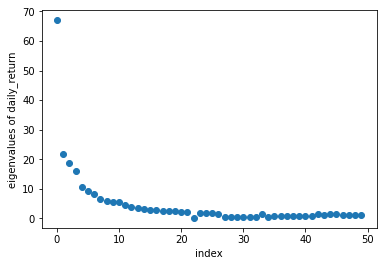

In [311]:
cov_daily = np.cov(daily_returns.values.T, rowvar=False)
e_daily = np.linalg.eigvals(cov_daily)
plt.plot(e_daily,'o')

def calculate_weights(cov_mat, mu):
    one_vector = np.ones([1,cov_mat.shape[1]]).T # 50 by 1
    inv_cov = np.linalg.inv(cov_mat) # 50 by 50
    mu_target = 0.04
    
    A = mu @ inv_cov @ one_vector 
    B = mu @ inv_cov @ mu.T 
    C = one_vector.T @ inv_cov @ one_vector
    D = B*C - A*A
    
    w_eff = ((B * inv_cov @ one_vector).reshape(50,1) - (A * inv_cov @ mu.T).reshape(50,1) +
             mu_target * ((C*inv_cov@mu.T).reshape(50,1) - (A*inv_cov@one_vector).reshape(50,1)))/D

    return w_eff

def calculate_risk(w_eff):
    return w_eff.T / T @ cov_daily @ w_eff

portfolio_weights_diag = np.diag(np.diag(cov_daily))

# risk-adjusted return
alpha = daily_returns - Loadings @ Factors
alpha = np.mean(alpha,axis=1)

w = calculate_weights(SigmaY, alpha)
w2 = calculate_weights(portfolio_weights_diag, alpha)

risk_POET = calculate_risk(w)
risk_DIAG = calculate_risk(w2)

print("risk_POET: ",risk_POET)
print("risk_DIAG: ",risk_DIAG)

plt.xlabel("index")
plt.ylabel("eigenvalues of daily_return")
plt.show()

### Extra Code: Banding
Implementation of Banding model. k found = 1.

In [187]:
from sklearn.model_selection import train_test_split

def banding(mat):
    # Estimate k using the empirical risk function 
    min_k = (np.inf, 0)

    for i in range (1,8): # most of the time number of variables kept is less than 8
        risk = 0
        random_test = 1000
        for j in range(random_test): # Take the average of 1000 simulations
            # Divide the dataset into two parts
            X_train, X_test = train_test_split(mat)
            estimiated_cov = np.cov(X_train, rowvar=False) 
            # do banding 
            for m in range(estimiated_cov.shape[1]):
                for n in range(estimiated_cov.shape[1]):
                    if abs(m-n)>i:
                        estimiated_cov[m,n] = 0
            test_cov = np.cov(X_test, rowvar=False)
            # calculate the estimated risk
            risk += np.linalg.norm(estimiated_cov-test_cov) # frobenius norm
        #Take the average of risk
        risk /= random_test
        if (risk < min_k[0]):
            min_k = (risk, i)
            
    k = min_k[1]         

    # Conduct banding: set all entries where |i-j|>k to 0
    cov_mat = np.cov(mat, rowvar=False)
    # do banding 
    for m in range(cov_mat.shape[1]):
        for n in range(cov_mat.shape[1]):
            if abs(m-n)>k:
                cov_mat[m,n] = 0
    return cov_mat, k

cov_mat, k = banding(de_meaned_mat)
print("k = ", k)

k =  1
